## Notebook to train an Advection-Aware AutoEncoder for a parametric 2D Linear Advection example


Consider the advection of a circular Gaussian pulse traveling in the positive $y-$direction through a rectangular domain, $\Omega = [-100,100] \times [0, 500]$ at a constant speed, $c$. The analytical solution is given by
\begin{align}\label{eq:Gaussian_pulse}
    u(x,y) = \exp{ \bigg\{ -\left(\frac{(x -x_0)^2}{2 \sigma_x^2} + \frac{(y - y_0 - ct)^2}{2 \sigma_y^2} \right) \bigg\} },
\end{align}
where $(x_0, y_0)$ is the initial location of the center of the pulse, $\sigma_x$ and $\sigma_y$ define the support of the pulse in the $x$ and $y$ directions, respectively. The domain is uniformly discretized into $100701$ computational nodes using $\Delta x = 1$ and $\Delta y = 1$.

In [1]:
## Load modules
%matplotlib inline

import numpy as np
import scipy
import os
import gc
import time
import importlib
from importlib import reload as reload


from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

import tensorflow as tf
print("Tensorflow v"+str(tf.__version__))
if tf.__version__ == '1.15.0':
    tf.compat.v1.enable_eager_execution()
elif tf.__version__.split('.')[0] == 2: # in ['2.2.0','2.3.0']:
    print("Setting Keras backend datatype")
    tf.keras.backend.set_floatx('float32')
    tf.debugging.set_log_device_placement(True)

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# tf.keras.backend.set_floatx('float64')

np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, 
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x','D','H','v','*'])

try:
    os.listdir(base_dir)
except:
    base_dir = os.getcwd()
utils_dir  = os.path.join(base_dir,'../src/utils')
nn_dir  = os.path.join(base_dir,'../src/nn_model')
work_dir = os.path.join(base_dir,'../examples')
data_dir = os.path.join(base_dir,'../data/')
model_dir = os.path.join(base_dir,'../data/saved_models/ae_param_models/')
fig_dir  = os.path.join(base_dir,'../figures/')


os.chdir(utils_dir)
import data_utils as du
import tf_utils as tu
import plot_utils as pu

os.chdir(nn_dir)
import aa_autoencoder as aa
os.chdir(work_dir)



Tensorflow v2.5.0


In [2]:
device = 'gpu:0' # select gpu:# or cpu:#


# Uncomment the following when training for variable pulse size
param_list = [5, 8, 10, 16, 20, 24]; flag = 'sigma';  # pulse geometry as a parameter
param_train = [5, 10, 16]; param_test = [8, 20]



In [3]:
## Load snapshot data
model ='Pulse'
soln_names = ['pulse']

snap_data = {}; times_offline = {}
c = {}; sigma = {}
snap_start = {}; snap_end = {}

for indx,val in enumerate(param_train):
    if flag == 'sigma':
        datafile = 'Gaussian2d_pulse_500x200_c1.00_sigma'+'%.4f'%val+'.npz'
    elif flag == 'speed':
        datafile = 'Gaussian2d_pulse_500x200_c'+'%.2f'%val+'_sigma5.0000.npz'
    data = np.load(os.path.join(data_dir, datafile))
    
    c[indx] = float(datafile.split('_c')[1].split('_')[0])
    sigma[indx] = float(datafile.split('_sigma')[1].split('.npz')[0])
    print("\n%d: Loading snapshots for c = %f, sigma = %f"%(indx, c[indx], sigma[indx]))
    
    snap_data[indx], times_offline[indx], nodes, Nx, Ny, snap_start[indx], snap_end[indx] = du.read_data(data, soln_names)
    
del data
gc.collect()


0: Loading snapshots for c = 1.000000, sigma = 5.000000
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins

1: Loading snapshots for c = 1.000000, sigma = 10.000000
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins

2: Loading snapshots for c = 1.000000, sigma = 16.000000
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins


190

In [4]:
## Prepare training snapshots

Nn = Nx * Ny

## number of steps to skip in selecting training snapshots for SVD basis
snap_incr=2

## Subsample snapshots for building reduced basis
Nt = {}
Nt_train = {}
train_end = {}
for indx,val in enumerate(param_train):
    Nt[indx] = times_offline[indx].size
    train_end[indx] = int(Nt[indx]*1.00)
    Nt_train[indx] = times_offline[indx][:train_end[indx]+1:snap_incr].size
    print('{5}: Using {0} training snapshots for {1} = {2:.2f} in time interval [{3:.2f},{4:.2f}] mins'.format(
            Nt_train[indx], flag, param_train[indx], times_offline[indx][:train_end[indx]+1:snap_incr][0]/60, 
            times_offline[indx][:train_end[indx]+1:snap_incr][-1]/60, indx))



0: Using 210 training snapshots for sigma = 5.00 in time interval [0.00,6.97] mins
1: Using 210 training snapshots for sigma = 10.00 in time interval [0.00,6.97] mins
2: Using 210 training snapshots for sigma = 16.00 in time interval [0.00,6.97] mins


In [5]:
def set_label(key):
    if key == 'pulse':
        ky = 'u'
    
    return ky

In [6]:
## Load shifted snapshots   
print("Loading high-fidelity shifted snapshots -----\n")

shifted_snap = {}
for indx,val in enumerate(param_train):
    if flag == 'sigma':
        shift_datafile = 'Shift_Gaussian2d_pulse_500x200_c1.00_sigma'+'%.4f'%val+'.npz'
    elif flag == 'speed':
        shift_datafile = 'Shift_Gaussian2d_pulse_500x200_c'+'%.2f'%val+'_sigma5.0000.npz'
    
    print("\nReading data from %s"%shift_datafile)
    shift_data = np.load(os.path.join(data_dir, shift_datafile))
    shifted_snap[indx] = {}
    for key in soln_names:
        shifted_snap[indx][key] = np.outer(shift_data[key].reshape((Nn,-1)),np.ones(Nt[indx]))

        print("%d: Loading %d shifted snapshots for c = %f, sigma = %f, key = %s"%(indx, 
                                                            shifted_snap[indx][key].shape[1], 
                                                            c[indx], sigma[indx], key))
        
del shift_data
gc.collect()


Loading high-fidelity shifted snapshots -----


Reading data from Shift_Gaussian2d_pulse_500x200_c1.00_sigma5.0000.npz
0: Loading 420 shifted snapshots for c = 1.000000, sigma = 5.000000, key = pulse

Reading data from Shift_Gaussian2d_pulse_500x200_c1.00_sigma10.0000.npz
1: Loading 420 shifted snapshots for c = 1.000000, sigma = 10.000000, key = pulse

Reading data from Shift_Gaussian2d_pulse_500x200_c1.00_sigma16.0000.npz
2: Loading 420 shifted snapshots for c = 1.000000, sigma = 16.000000, key = pulse


84

In [7]:
###  ***** Prepare Autoencoder input data *******
## 1. Concatenate parametric snapshots to prepare
##    input features for AA Autoencoder training

u = np.empty((0,Nn),)
u_shift = np.empty((0,Nn),)

for indx,val in enumerate(param_train):
    u_snap = snap_data[indx]['pulse'][:,:train_end[indx]+1:snap_incr].T    
    u = np.vstack((u,u_snap))
    u_shift_snap = shifted_snap[indx]['pulse'][:,:train_end[indx]+1:snap_incr].T
    u_shift = np.vstack((u_shift,u_shift_snap))
    

validation_data = True
skip_start = snap_incr//2
if validation_data:
    u_val = np.empty((0,Nn),)
    u_val_shift = np.empty((0,Nn),)
    for indx,val in enumerate(param_train):
        u_val_snap = snap_data[indx]['pulse'][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val_shift_snap = shifted_snap[indx]['pulse'][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val = np.vstack((u_val, u_val_snap))
        u_val_shift = np.vstack((u_val_shift, u_val_shift_snap))
    

In [8]:
## Scale Input Features to lie between [0,1]

scaling=True

if scaling:
    u, u_shift, u_max, u_min = du.data_scaler(u, u_shift)

    if validation_data:
        u_val, u_val_shift, _, _ = du.data_scaler(u_val, u_val_shift, u_max, u_min)
        
else:
    u_max = np.maximum(u.max(), u_shift.max()); u_min = np.minimum(u.min(), u_shift.min())

    

In [9]:
###  ***** Prepare Autoencoder input data *******
## 2. Augment input feature states with scaled 
##    parameter values

u_sigma = np.empty((0,1),)
u_shift_sigma = np.empty((0,1),)

p_max = np.asarray(param_list).max()
for indx,val in enumerate(param_train/p_max):
    u_sigma = np.vstack((u_sigma,val*np.ones((Nt_train[indx],1))))
    u_shift_sigma = np.vstack((u_shift_sigma,val*np.ones((Nt_train[indx],1)) ))
    
u = np.hstack(( u,u_sigma))
u_shift = np.hstack(( u_shift, u_shift_sigma))


if validation_data:
    u_val_sigma = np.empty((0,1),)
    u_val_shift_sigma = np.empty((0,1),)
    for indx,val in enumerate(param_train/p_max):
        val_steps = np.minimum(times_offline[indx][skip_start:train_end[indx]+1:snap_incr].size, Nt_train[indx])
        u_val_sigma = np.vstack((u_val_sigma, val*np.ones((val_steps,1)) ))
        u_val_shift_sigma = np.vstack((u_val_shift_sigma, val*np.ones((val_steps,1)) ))
        
        
    u_val = np.hstack(( u_val, u_val_sigma))
    u_val_shift = np.hstack(( u_val_shift, u_val_shift_sigma))


In [10]:
## Design of the AA autoencoder sub-networks

size0 = u.shape[1]
size1 = int(np.floor(size0//160))
size2 = int(np.floor(size0//400))
size3 = int(np.floor(size0//1600))

size = np.array([size0, size1, size2, size3])
epochs_u = 8000

## Uncomment For model AA1
latent_dim_u = 15
augment_output = False
batch_size = 32
init_lr = 1e-4

# ## Uncomment For model AA2
# latent_dim_u = 15
# augment_output = True
# batch_size = 24
# init_lr = 1e-4

print("Full order dimension: ",size0-1)
print("Latent dimension: ",latent_dim_u)


Full order dimension:  100701
Latent dimension:  15


In [11]:
## Define minibatch generators for training and
## validation using Tensorflow Dataset API


size_buffer = max(list(Nt_train.values()))
    
u_train, u_val = tu.gen_batch_ae(u, u_shift, u_val, u_val_shift, 
                                 batch_size=batch_size, shuffle_buffer=size_buffer)


In [12]:
## Custom training loop for AA Autoencoder model

def train_AAautoencoder(epochs, train_dataset, val_dataset, latent_dim, actvn, size, Nt, 
                        augment_output = True, **kwargs):
    
    loss_wt = kwargs['loss_weights']
    model = aa.AAautoencoder(latent_dim, actvn, size, augment_output = augment_output)
    
    try:
        learn_rate = kwargs['lr']
    except:
        learn_rate = 0.0001
    try:
        batch_size = kwargs['batch_size']
    except:
        batch_size = 64
    try:
        reg_wt = kwargs['reg']
    except:
        reg_wt = 0.02
        
    try:
        lb = kwargs['loss_lb']
    except:
        lb = 0.9
        
    try:
        decay_factor = kwargs['decay'][0]; decay_rate = kwargs['decay'][1]
    except:
        decay_factor = 15; decay_rate = 0.9
    
    try: 
        learning_rate_decay = kwargs['lr_decay']
        init_learn_rate = tf.keras.optimizers.schedules.ExponentialDecay(learn_rate, 
                                                        decay_steps=epochs*Nt//batch_size//decay_factor,
                                                        decay_rate=decay_rate, staircase=True)
    except:
        init_learn_rate = learn_rate
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=init_learn_rate)
    

    train_loss = []
    val_loss = []
    shift_loss = []
    recon_loss = []
    lr = []
    regu_loss = []
    start_time = time.time()
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        # Iterate over the batches of the dataset.
        train_loss_value = 0; 
        shift_loss_value = 0; 
        recon_loss_value = 0;
        rloss_value = 0
        for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:

                # Run the forward pass of the layer.
              
                
                ## Encoded output for this minibatch
                encoded = model.encoder(x_batch_train, training=True)
                
                ## Shift Decoder Evaluation for this minibatch
                pred = model.shift(encoded, training=True)  
                
                ## True Decoder Evaluation for this minibatch
                recon = model.decoder(encoded, training=True)
                
                ## L2 Regularization Loss Component
                l2_loss=tf.add_n(model.losses)
                
               
                ## Compute the loss value for this minibatch.
                if augment_output:
                    loss1 = tu.comb_loss(y_batch_train[:,:], pred, lb=lb, delta=0.5) #\
                    loss2 = tu.comb_loss(x_batch_train[:,:], recon, lb=lb, delta=0.5) #\
                else:
                    loss1 = tu.comb_loss(y_batch_train[:,:-1], pred, lb=lb, delta=0.5) #\
                    loss2 = tu.comb_loss(x_batch_train[:,:-1], recon, lb=lb, delta=0.5) #\
                    
                if epoch < kwargs['segmented']:
                    loss_value = loss_wt[0] * loss1 + loss_wt[1] * loss2 
                else:
                    loss_value = loss_wt[2] * loss1 + loss_wt[3] * loss2
                
                reg_loss = reg_wt*tf.sqrt(l2_loss)/(epoch+1)
                loss_value += reg_loss
                rloss_value +=reg_loss
                       
            train_loss_value += loss_value
            shift_loss_value += loss1
            recon_loss_value += loss2
            
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_variables,
                        unconnected_gradients=tf.UnconnectedGradients.ZERO) 
            ## Suppress warnings about zero gradients during training
            
            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Log every 10 batches.
            if step_train % 10 == 0:
                print("Training loss for batch %d: Shift: %.4e, Recon: %.4e, Reg: %.4e"
                    % ((step_train+1), float(loss1), float(loss2), float(reg_loss)))
                print("Seen so far: %s samples" % ((step_train + 1) * batch_size))
                
        train_loss.append((train_loss_value/(step_train + 1)).numpy())
        shift_loss.append((shift_loss_value/(step_train + 1)).numpy())
        recon_loss.append((recon_loss_value/(step_train + 1)).numpy())
        regu_loss.append((rloss_value/(step_train + 1)).numpy())
        
        # Run a validation loop at the end of each epoch.
        val_loss_value = 0; 
        for step_val, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            
            encoded_val = model.encoder(x_batch_val, training=False)
            pred_val = model.shift(encoded_val, training=False)
            recon_val = model.decoder(encoded_val, training=False)
            
            if augment_output:
                loss_val1 = tu.comb_loss(y_batch_val[:,:], pred_val, lb=lb,delta=0.5) #\
                loss_val2 = tu.comb_loss(x_batch_val[:,:], recon_val, lb=lb,delta=0.5) #\
            else:
                loss_val1 = tu.comb_loss(y_batch_val[:,:-1], pred_val, lb=lb,delta=0.5) #\
                loss_val2 = tu.comb_loss(x_batch_val[:,:-1], recon_val, lb=lb,delta=0.5) #\
                
            if epoch < kwargs['segmented']:
                val_loss_value += loss_wt[0] * loss_val1 + loss_wt[1] * loss_val2 
            else:
                val_loss_value += loss_wt[2] * loss_val1 + loss_wt[3] * loss_val2
        
        val_loss_value += rloss_value
        val_loss.append((val_loss_value/(step_val+1)).numpy())
        
        if learning_rate_decay:
            print("Epoch %d, Training Loss: %.4e, Validation Loss: %.4e. LR: %.4e" 
                  % (epoch, float(train_loss[-1]),float(val_loss[-1]),init_learn_rate(optimizer.iterations).numpy()))
            lr.append(init_learn_rate(optimizer.iterations).numpy())
        else:
            print("Epoch %d, Training Loss: %.4e, Validation Loss: %.4e. LR: %.4e" 
                  % (epoch, float(train_loss[-1]),float(val_loss[-1]),learn_rate))
            lr.append(learn_rate)

    
    end_time = time.time()
    print("****Total training time = {0}****\n".format(end_time - start_time))
    
    return model, train_loss, val_loss, shift_loss, recon_loss, lr


In [13]:
## Load AE model

load_ae_model = True

if load_ae_model:
    pre_trained_dir = model_dir+'saved_model_AA1'  ## For Model AA1
#     pre_trained_dir = model_dir+'saved_model_AA2'  ## For Model AA2
    mnum = pre_trained_dir.split('saved_model_')[1]

    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does not
    ##   search for loss functions
    
    u_autoencoder, model_training = aa.load_model(pre_trained_dir,mnum)
    
    print(model_training['msg'])

    loss_u = model_training['loss']
    vloss_u = model_training['valloss'] 
    sloss_u = model_training['shiftloss'] 
    rloss_u = model_training['reconloss'] 
    lr_u = model_training['lr']
    epochs_u = model_training['epochs']
    u_max2 = model_training['umax']; 
    u_min2 = model_training['umin']; 
    augment_output2 = model_training['augment'];

    ## Check that model parameters were set correctly for 
    ## the chosen pre-trained model
    assert u_max2 == u_max
    assert u_min2 == u_min
    assert augment_output2 == augment_output

Sigma = [5,10,16], speed = [1], train_end = 1.0*T,
Trains both shift and true decoder, Time = 4h 27m 46s,
Step decay LR scheduler starting from 1.00e-04, Batch Size = 32,
Decaying 15% every 456 epochs. Trained for 8000 epochs,
For epochs <=2500: Loss = 0.00*Shift + 0.98*True,
For epochs > 2500: Loss = 0.10*Shift + 0.88*True,
90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],
Only Encoder input is augmented by parameter value


In [14]:
## Training the AA Autoencoder Model


if not load_ae_model:
    init_time = time.time()


    ### Uncomment for Model AA1 training
    actvn = tf.keras.activations.selu
    u_autoencoder, loss_u, vloss_u, sloss_u, rloss_u, lr_u = train_AAautoencoder(epochs_u, u_train, u_val, 
                                              latent_dim_u, actvn, np.array([size[0], size[2], size[3]]),  
                                              sum(list(Nt_train.values())),
                                              augment_output = augment_output,
                                              batch_size = batch_size, loss_lb = 0.9,
                                              segmented = 2500, decay = [17, 0.85],
                                              loss_weights = [0.0, 0.98, 0.1, 0.88],
                                              lr = init_lr, lr_decay = True, reg = 0.02 )
    
    
#     ### Uncomment for Model AA2 training
#     actvn = tf.keras.activations.swish
#     u_autoencoder, loss_u, vloss_u, sloss_u, rloss_u, lr_u = train_AAautoencoder(epochs_u, u_train, u_val, 
#                                               latent_dim_u, actvn, size,  
#                                               sum(list(Nt_train.values())),
#                                               augment_output = augment_output,
#                                               batch_size = batch_size, loss_lb = 0.9,
#                                               segmented = 2500, decay = [17, 0.85],
#                                               loss_weights = [0.0, 0.98, 0.1, 0.88],
#                                               lr = init_lr, lr_decay = True, reg = 0.02 )

    end_time = time.time()
    train_time = end_time - init_time
    hrs = int(train_time//3600); rem_time = train_time - hrs*3600
    mins = int(rem_time//60); secs = int(rem_time%60)
    print('Training time: %d H %d M, %d S'%(hrs,mins,secs))

In [15]:
u_autoencoder.build(u.shape)
u_autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  63516886  
_________________________________________________________________
shift (Shift)                multiple                  63616943  
_________________________________________________________________
decoder (Decoder)            multiple                  63616943  
Total params: 190,750,772
Trainable params: 190,750,772
Non-trainable params: 0
_________________________________________________________________


In [16]:
encoded_u = u_autoencoder.encoder(u).numpy()
if augment_output:
    shift_u = u_autoencoder.shift(encoded_u).numpy()[:,:-1]
    decoded_u = u_autoencoder.decoder(encoded_u).numpy()[:,:-1]
else:
    shift_u = u_autoencoder.shift(encoded_u).numpy()
    decoded_u = u_autoencoder.decoder(encoded_u).numpy()
encoded = encoded_u


print('\n*********AE shifted decoder reconstruction error*********\n')
print('u  Shift MSE: ' + str(np.mean(np.square(du.scaler_inverse(shift_u, u_max, u_min, scaling=scaling)-du.scaler_inverse(u_shift[:,:-1], u_max, u_min, scaling=scaling)))))

print('\n*********AE inverse decoder reconstruction error*********\n')
print('u  Reconstruction MSE: ' + str(np.mean(np.square(du.scaler_inverse(decoded_u, u_max, u_min, scaling=scaling)-du.scaler_inverse(u[:,:-1], u_max, u_min, scaling=scaling)))))



*********AE shifted decoder reconstruction error*********

u  Shift MSE: 1.2139106642011908e-07

*********AE inverse decoder reconstruction error*********

u  Reconstruction MSE: 1.951937701361138e-07


In [17]:
## Save the trained AE model

if not load_ae_model:
    

    if flag == 'sigma':
        savedir = model_dir+'saved_model_AA1'
#         savedir = model_dir+'saved_model_AA2'

    if not os.path.exists(savedir):
        os.mkdir(savedir)

    mnum = savedir.split('saved_model_')[1]
    
    if flag == 'sigma':
        msg = 'Sigma = [5,10,16], speed = [1], train_end = 1.0*T,'\
        +'\nTrains both shift and true decoder, Time = %dh %dm %ds,'%(hrs,mins,secs)\
        +'\nStep decay LR scheduler starting from %.2e, Batch Size = %d,'%(init_lr,batch_size)\
        +'\nDecaying 15% every 456 epochs.'+' Trained for %d epochs,'%(epochs_u)\
        +'\nFor epochs <=2500: Loss = 0.00*Shift + 0.98*True,'\
        +'\nFor epochs > 2500: Loss = 0.10*Shift + 0.88*True,'\
        +'\n90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],'\
        +'\nOnly Encoder input is augmented by parameter value'
    print("\n===========")
    print(msg)
    
    
    model_results = {'loss': loss_u, 'valloss': vloss_u,
                     'shiftloss': sloss_u, 'reconloss': rloss_u,
                     'lr': lr_u, 'epochs': epochs_u, 'msg': msg,
                     'umax': u_max, 'umin': u_min,
                     'savedir': savedir, 'augment': augment_output,}
    
    aa.save_model(u_autoencoder, u, mnum, model_results)
    


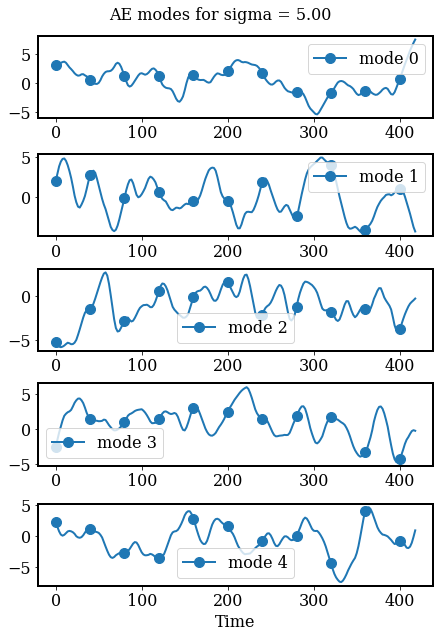

In [18]:
param_num = 0

def select_variable(param_num):
    p_indx = sum(list(Nt_train.values())[:param_num]); 
    encoded = encoded_u[p_indx:p_indx+Nt_train[param_num]]; ldim = latent_dim_u
    return encoded, ldim

def plot_latent_param_nums(param_num):

    num_rows = 5 #np.maximum(4, encoded.shape[1]//4)
    fig, ax = plt.subplots(nrows=num_rows,ncols=1,figsize=(6,num_rows*1.75),constrained_layout=True)    

    for ix,comp in enumerate([param_num]):
        encoded, ldim = select_variable(comp)
        
        for i in range(num_rows):
            tt = ax[i].plot(times_offline[comp][:train_end[comp]+1:snap_incr],encoded[:,i],label='mode %d'%i,marker='o',markevery=20)
            ax[i].legend()
        ax[i].set_xlabel('Time')  
        fig.suptitle('AE modes for %s = %.2f'%(flag, param_train[param_num]),fontsize=16)  


plot_latent_param_nums(param_num)


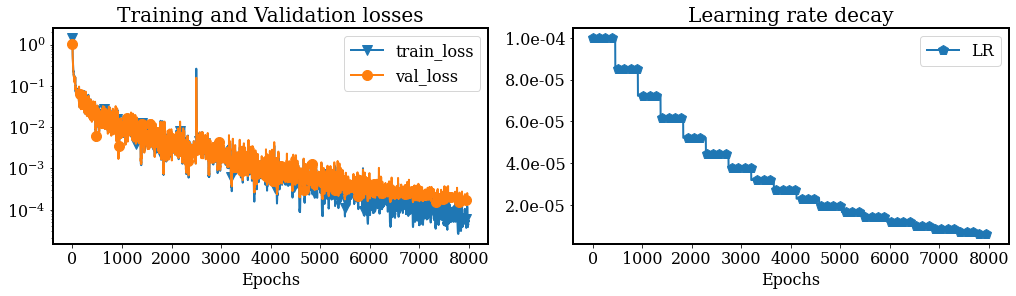

In [19]:
## Visualization losses and learning rate evolution
num_epochs_u = np.arange(epochs_u)

pu.plot_training(num_epochs_u, loss_u, vloss_u, lr_u)


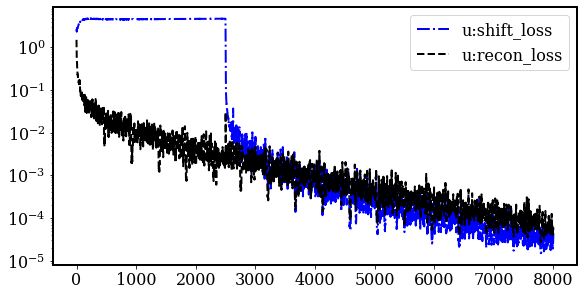

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4),constrained_layout=True)
ax.semilogy(num_epochs_u, sloss_u,'b-.',label='u:shift_loss')
ax.semilogy(num_epochs_u, rloss_u,'k--',label='u:recon_loss')
ax.legend()


In [21]:
### Predict using all high-fidelity data points 
### for parameter values in the training set

iparam = np.random.choice(len(param_train))
print("Testing AE predictions for %s = %f (parameter number = %d)"%(flag,param_train[iparam], iparam))
val = param_train[iparam]/p_max

u_test = snap_data[iparam]['pulse'][:,:snap_end[iparam]+1].T
u_shift_test = shifted_snap[iparam]['pulse'][:,:snap_end[iparam]+1].T
if scaling:
    u_test, u_shift_test, _, _ = du.data_scaler(u_test, u_shift_test, u_max, u_min)

u_test = np.hstack((u_test , val*np.ones((Nt[iparam],1)) ))
u_shift_test = np.hstack((u_shift_test , val*np.ones((Nt[iparam],1)) ))



encoded_u_test = u_autoencoder.encoder(u_test).numpy()
if augment_output:
    shift_u_test = u_autoencoder.shift(encoded_u_test).numpy()[:,:-1]
    decoded_u_test = u_autoencoder.decoder(encoded_u_test).numpy()[:,:-1]
else:
    shift_u_test = u_autoencoder.shift(encoded_u_test).numpy()
    decoded_u_test = u_autoencoder.decoder(encoded_u_test).numpy()

pred_shift = {}
pred_shift['pulse'] = du.scaler_inverse(shift_u_test, u_max, u_min, scaling=scaling).T

pred_recon = {}
pred_recon['pulse'] = du.scaler_inverse(decoded_u_test, u_max, u_min, scaling=scaling).T


Testing AE predictions for sigma = 5.000000 (parameter number = 0)


Text(0.5, 0.98, 'Comparing AE predictions of shifted snapshots \nfor sigma = 5 at t = 6.92 mins')

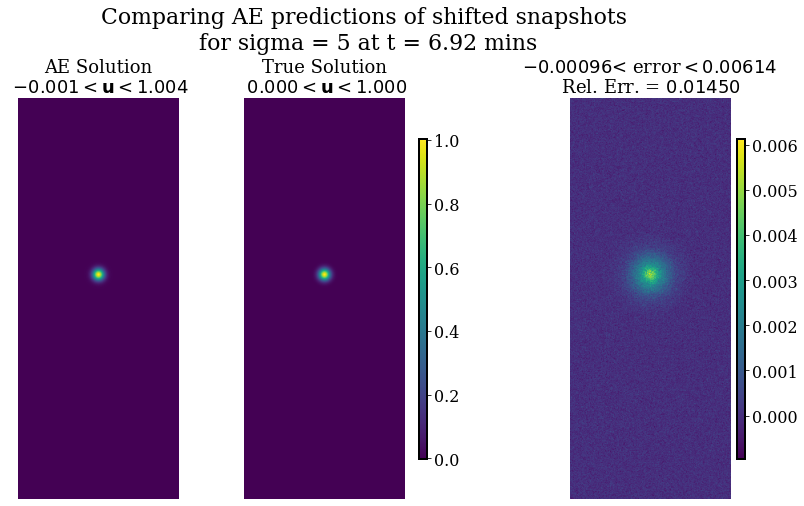

In [22]:
### Visualizing reconstruction of shifted snapshots using shift decoder  
    
fig = plt.figure(figsize=(14,8))
ky = 'pulse'; 
np.random.seed(2021)
iplot = times_offline[iparam].size-5 
fig.tight_layout()
fig.subplots_adjust(top=0.82)

pu.compare_soln(pred_shift,shifted_snap[iparam],iplot,times_offline[iparam],times_offline[iparam],
                Nx,Ny,ky,flag='AE')
fig.suptitle("Comparing AE predictions of shifted snapshots \nfor %s = %d at t = %.2f mins"%(flag, param_train[iparam], times_offline[iparam][iplot]/60),fontsize=22, y=0.98)


Text(0.5, 0.98, 'Comparing AE predictions of true snapshots \nfor sigma = 5 at t = 6.92 mins')

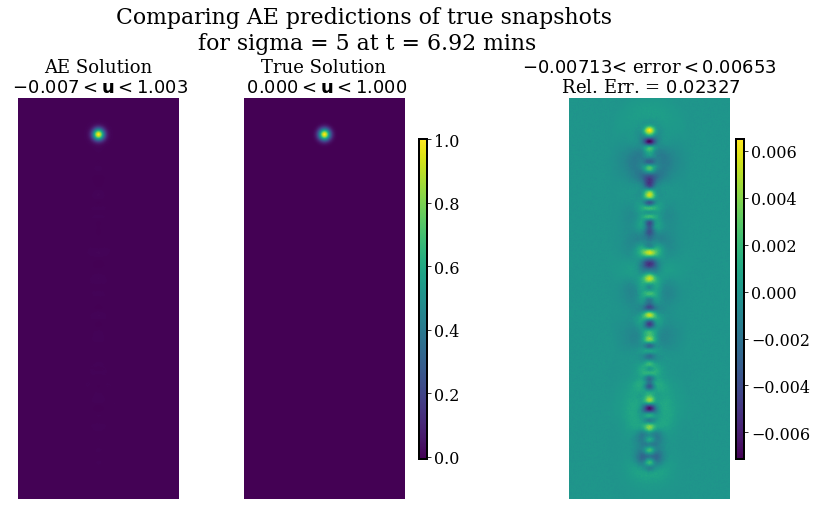

In [23]:
### Visualizing direct reconstruction using true decoder

fig = plt.figure(figsize=(14,8))
fig.tight_layout()
fig.subplots_adjust(top=0.82)

pu.compare_soln(pred_recon,snap_data[iparam],iplot,times_offline[iparam],times_offline[iparam],
                Nx,Ny,ky,flag='AE')
fig.suptitle("Comparing AE predictions of true snapshots \nfor %s = %d at t = %.2f mins"%(flag, param_train[iparam], times_offline[iparam][iplot]/60),fontsize=22, y=0.98)



In [26]:
## Evaluate predictions on a dataset with unseen parameter value

new_test = True

if new_test:        

    test_param = np.random.choice(param_test)  
    c_new = 1; sigma_new = test_param
    print("Chosen parameter: %s = %f"%(flag, test_param))
    print("\nLoading pre-computed true snapshots -----")

    new_data = np.load(os.path.join(data_dir,'Gaussian2d_pulse_500x200_c1.00_sigma%.4f.npz'%sigma_new))
    snap_new, times_new, nodes2, Nx2, Ny2, snap_start_new, snap_end_new = du.read_data(new_data, soln_names)
    Nt_new = times_new.size

    
    print("\nLoading pre-computed shifted snapshots -----")
    new_shift_data = np.load(os.path.join(data_dir,'Shift_Gaussian2d_pulse_500x200_c1.00_sigma%.4f.npz'%sigma_new))
    shifted_snap_new = {}
    for key in soln_names:
        tmp = new_shift_data[key].reshape((Nn,-1))
        shifted_snap_new[key] = np.outer(tmp,np.ones(Nt_new))

    del new_data
    del new_shift_data
    gc.collect()



    u_new = snap_new['pulse'][:,:snap_end_new+1].T
    u_shift_new = shifted_snap_new['pulse'][:,:snap_end_new+1].T
    if scaling:
        u_new, u_shift_new, _, _ = du.data_scaler(u_new, u_shift_new, u_max, u_min)

    u_new = np.hstack(( u_new, (test_param/p_max)*np.ones((Nt_new,1)) ))
    u_shift_new = np.hstack(( u_shift_new, (test_param/p_max)*np.ones((Nt_new,1)) ))

    
    encoded_u_new = u_autoencoder.encoder(u_new).numpy()
    if augment_output:
        shift_u_new = u_autoencoder.shift(encoded_u_new).numpy()[:,:-1]
        decoded_u_new = u_autoencoder.decoder(encoded_u_new).numpy()[:,:-1]
    else:
        shift_u_new = u_autoencoder.shift(encoded_u_new).numpy()
        decoded_u_new = u_autoencoder.decoder(encoded_u_new).numpy()

    pred_shift_new = {}
    pred_shift_new['pulse'] = du.scaler_inverse(shift_u_new, u_max, u_min, scaling=scaling).T

    pred_recon_new = {}
    pred_recon_new['pulse'] = du.scaler_inverse(decoded_u_new, u_max, u_min, scaling=scaling).T



Chosen parameter: sigma = 8.000000

Loading pre-computed true snapshots -----
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins

Loading pre-computed shifted snapshots -----


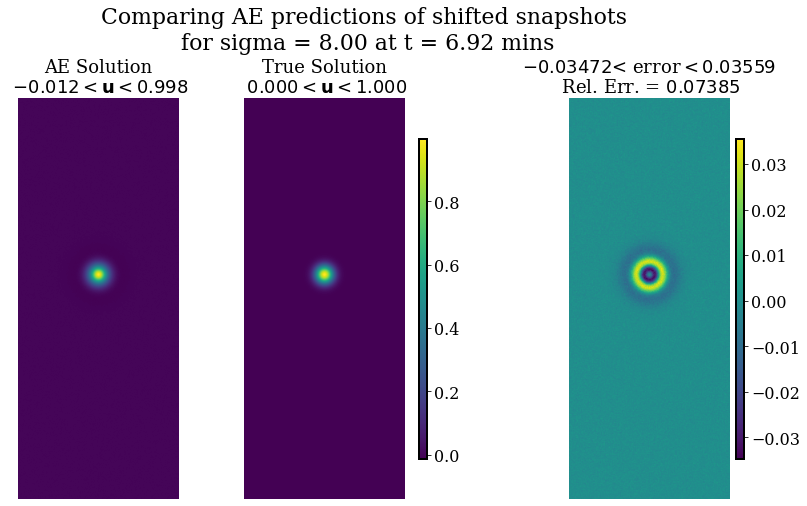

In [27]:
### Visualizing reconstruction of shifted snapshots using shift decoder
if new_test:
    fig = plt.figure(figsize=(14,8))
    ky = 'pulse'; iplot = times_new.size-5 #20 #np.random.choice(times_new.size)
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    pu.compare_soln(pred_shift_new,shifted_snap_new,iplot,times_new,times_new,
                    Nx,Ny,ky,flag='AE')
    fig.suptitle("Comparing AE predictions of shifted snapshots \nfor %s = %.2f at t = %.2f mins"%(flag, test_param, times_new[iplot]/60),fontsize=22, y=0.98)



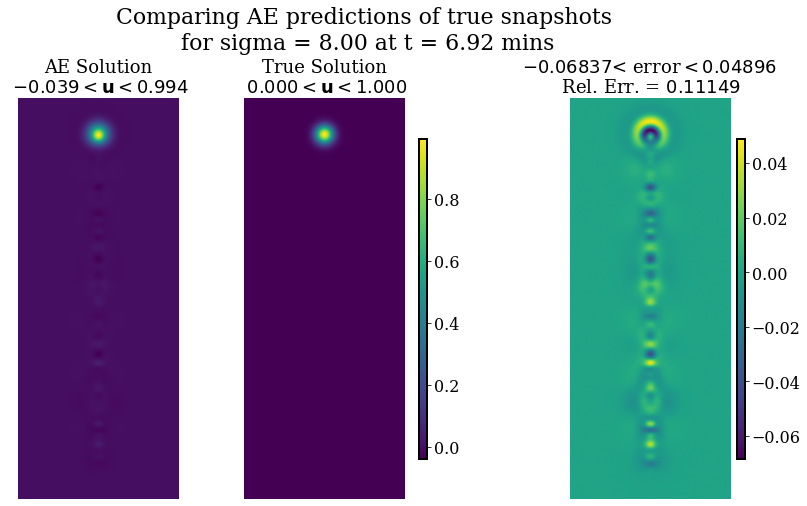

In [28]:
### Visualizing direct reconstruction using true decoder
if new_test:
    fig = plt.figure(figsize=(14,8))
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    pu.compare_soln(pred_recon_new,snap_new,iplot,times_new,times_new,
                    Nx,Ny,ky,flag='AE')
    fig.suptitle("Comparing AE predictions of true snapshots \nfor %s = %.2f at t = %.2f mins"%(flag, test_param, times_new[iplot]/60),fontsize=22, y=0.98)

